
# Coagulation with Charge Effects
In this tutorial, we explore how electrical charge influences the coagulation (collisions and coalescence) of aerosol particles. We will:
- Create a size distribution for aerosol particles.
- Calculate the Coulomb potential ratio and related properties.
- Compute the coagulation kernel considering charge effects.
- Plot the coagulation kernel.
- Simulate the time evolution of the particle size distribution due to coagulation.
- Plot the particle concentration and coagulation rates.

*Import Necessary Libraries*
We import standard libraries like `numpy` and `matplotlib` for numerical computations and plotting. We also import specific functions from the `particula` package, which is used for aerosol dynamics simulations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# particula imports
from particula.dynamics.coagulation import brownian_kernel, rate
from particula.particles.properties.lognormal_size_distribution import (
    lognormal_pmf_distribution,
)
from particula.dynamics.coagulation.transition_regime import coulomb_chahl2019
from particula.particles.properties import (
    coulomb_enhancement,
    diffusive_knudsen_number,
    friction_factor,
    cunningham_slip_correction,
    calculate_knudsen_number,
)
from particula.gas.properties import (
    get_dynamic_viscosity,
    molecule_mean_free_path,
)
from particula.util.reduced_quantity import reduced_self_broadcast

from particula.dynamics.coagulation import kernel
from particula.dynamics.coagulation import rate
from particula.particles.properties.lognormal_size_distribution import lognormal_pmf_distribution

## Define the Particle Size Distribution
We create a size distribution for aerosol particles using a logarithmic scale for particle radius, ranging from 1 nm to 10 μm. We calculate the mass of particles in each size bin assuming they are spherical and have a standard density.
 Define the bins for particle radius using a logarithmic scale

In [2]:
radius_bins = np.logspace(start=-9, stop=-4, num=250)  # m (1 nm to 10 μm)

# Calculate the mass of particles for each size bin
# The mass is calculated using the formula for the volume of a sphere (4/3 * π * r^3)
# and assuming a particle density of 1 g/cm^3 (which is 1000 kg/m^3 in SI units).
mass_bins = 4 / 3 * np.pi * radius_bins**3 * 1e3  # kg

## Define Particle Charges
We assign charges to the particles. In this example, we assign negative charges to the first 33% of particles and positive charges to the remaining 66% of particles. The charges are assigned based on the particle radius, with negative charges ranging from 10 to 1 and positive charges ranging from 1 to 500. We then plot the charge distribution against the particle radius.
 Determine the number of radius bins

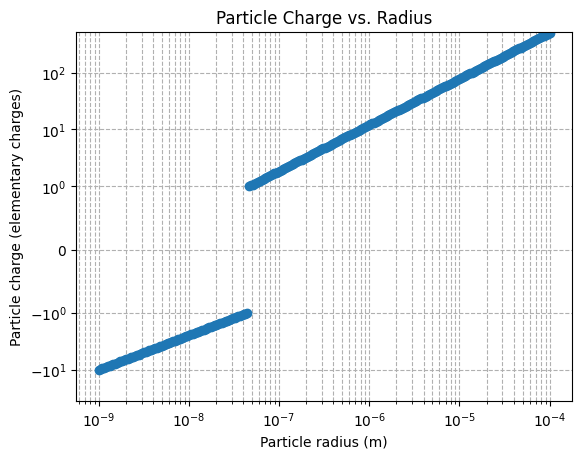

In [3]:
n_bins = len(radius_bins)

# Define the split index where charges transition from negative to positive
split_index = n_bins // 3  # Assign the first 25% of particles negative charges

# Generate logarithmically spaced magnitudes for negative charges from 10 to 1
neg_magnitudes = np.logspace(np.log10(10), np.log10(1), num=split_index)
neg_charges = -neg_magnitudes  # Assign negative sign

# Generate logarithmically spaced magnitudes for positive charges from 1 to 500
pos_magnitudes = np.logspace(np.log10(1), np.log10(500), num=n_bins - split_index)
pos_charges = pos_magnitudes  # Positive charges

# Combine the negative and positive charges into one array
charge_array = np.concatenate((neg_charges, pos_charges))

# Plot charge vs. radius
fig, ax = plt.subplots()
ax.plot(radius_bins, charge_array, marker='o', linestyle='none')
ax.set_xscale("log")
ax.set_yscale("symlog", linthresh=1)
ax.set_xlabel("Particle radius (m)")
ax.set_ylabel("Particle charge (elementary charges)")
ax.set_title("Particle Charge vs. Radius")
ax.grid(True, which="both", ls="--")
plt.show()

temperature = 298.15

## Calculate Coulomb Potential Ratio and Related Properties
In this section, we compute several properties necessary for calculating the coagulation kernel with charge effects:
- **Coulomb Potential Ratio**: Using `coulomb_enhancement.ratio`, we calculate the dimensionless Coulomb potential ratio, which quantifies the electrostatic interaction between charged particles.
- **Dynamic Viscosity**: Obtained from `get_dynamic_viscosity`, needed for calculating friction factors.
- **Mean Free Path**: Calculated using `molecule_mean_free_path`, important for determining the Knudsen number.
- **Knudsen Number**: Computed with `calculate_knudsen_number`, it characterizes the flow regime of the particles.
- **Slip Correction Factor**: Using `cunningham_slip_correction`, accounts for non-continuum effects at small particle sizes.
- **Friction Factor**: Calculated with `friction_factor`, needed for determining particle mobility.
- **Diffusive Knudsen Number**: Using `diffusive_knudsen_number`, combines the effects of particle diffusion and electrostatic interactions.

In [4]:
coulomb_potential_ratio = coulomb_enhancement.ratio(
    radius_bins, charge_array, temperature=temperature
)
dynamic_viscosity = get_dynamic_viscosity(temperature=temperature)
mol_free_path = molecule_mean_free_path(
    temperature=temperature, dynamic_viscosity=dynamic_viscosity
)
knudsen_number = calculate_knudsen_number(
    mean_free_path=mol_free_path, particle_radius=radius_bins
)
slip_correction = cunningham_slip_correction(knudsen_number=knudsen_number)


friction_factor_value = friction_factor(
    radius=radius_bins,
    dynamic_viscosity=dynamic_viscosity,
    slip_correction=slip_correction,
)

diffusive_knudsen_values = diffusive_knudsen_number(
    radius=radius_bins,
    mass_particle=mass_bins,
    friction_factor=friction_factor_value,
    coulomb_potential_ratio=coulomb_potential_ratio,
    temperature=temperature,
)

## Compute the Non-Dimensional Coagulation Kernel
The non-dimensional coagulation kernel is calculated using `coulomb_chahl2019`, which incorporates charge effects into the rate at which particles collide.

In [5]:
non_dimensional_kernel = coulomb_chahl2019(
    diffusive_knudsen=diffusive_knudsen_values,
    coulomb_potential_ratio=coulomb_potential_ratio,
)

## Calculate Coulomb Enhancement Factors
We compute the Coulomb enhancement factors in both the kinetic and continuum limits:
- **Kinetic Limit**: Using `coulomb_enhancement.kinetic`, applicable when particle motions are dominated by random thermal motion.
- **Continuum Limit**: Using `coulomb_enhancement.continuum`, applicable when particles are larger and motions are influenced by continuous fluid flow.

In [6]:
coulomb_kinetic_limit = coulomb_enhancement.kinetic(
    coulomb_potential_ratio
)
coulomb_continuum_limit = coulomb_enhancement.continuum(
    coulomb_potential_ratio
)

sum_of_radii = radius_bins[:, np.newaxis] + radius_bins[np.newaxis, :]
reduced_mass = reduced_self_broadcast(mass_bins)

## Compute the Dimensional Coagulation Kernel
The dimensional coagulation kernel combines all the previously calculated factors and gives the actual rate at which particles of different sizes collide and stick together due to coagulation, considering charge effects.

In [7]:
dimensional_kernel = (
    non_dimensional_kernel
    * friction_factor_value
    * sum_of_radii**3
    * coulomb_kinetic_limit**2
    / (reduced_mass * coulomb_continuum_limit)
)

## Plot the Coagulation Kernel
We plot the coagulation kernel as a function of particle radius to visualize how charge affects the coagulation rates across different particle sizes.

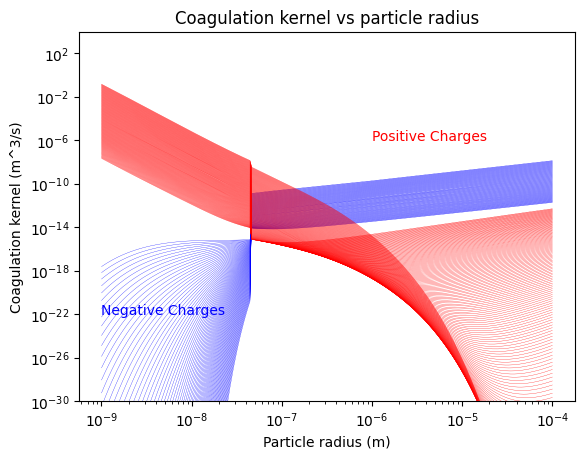

In [8]:
fig, ax = plt.subplots()

# Plot negative charges in blue
ax.plot(radius_bins, dimensional_kernel[:, :split_index], linewidth=0.2, color='blue', label='Negative Charges') 

# Plot positive charges in red
ax.plot(radius_bins, dimensional_kernel[:, split_index:], linewidth=0.2, color='red', label='Positive Charges')

# ax.legend()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(1e-30, 1e4)
ax.set_xlabel("Particle radius (m)")
ax.set_ylabel("Coagulation kernel (m^3/s)")
ax.set_title("Coagulation kernel vs particle radius")
ax.text(1e-9, 1e-22, "Negative Charges", color='blue')
ax.text(1e-6, 1e-6, "Positive Charges", color='red')
plt.show()

## Simulate Coagulation Over a Time Step
We calculate the gain and loss rates of particle concentrations due to coagulation using the previously computed kernel. The net rate of change in particle concentration is obtained by subtracting the loss rate from the gain rate.
 get rates of coagulation dn/dt
 make a number concentration distribution

In [9]:
number_concentration = lognormal_pmf_distribution(
    x_values=radius_bins,
    mode=np.array([10e-9, 200e-9, 1000e-9]),  # m
    geometric_standard_deviation=np.array([1.4, 1.5, 1.8]),
    number_of_particles=np.array([1e12, 1e12, 1e12]),  # per m^3
)

gain_rate = rate.discrete_gain(
    radius=radius_bins,
    concentration=number_concentration,
    kernel=dimensional_kernel,
)
loss_rate = rate.discrete_loss(
    concentration=number_concentration,
    kernel=dimensional_kernel,
)

net_rate = gain_rate - loss_rate

## Plot Particle Concentration and Coagulation Rates
We visualize the initial particle concentration distribution and the coagulation rates to understand how charge effects influence the coagulation process over time.
- **Particle Concentration**: Shows the number concentration of particles across different sizes.
- **Coagulation Rates**: Displays the gain, loss, and net rates of coagulation, highlighting how particles of different sizes contribute to the overall process.

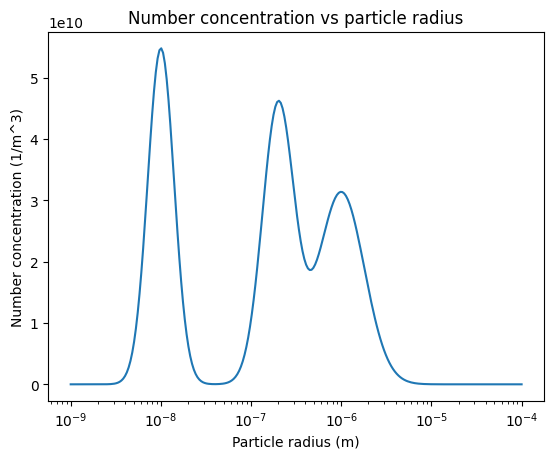

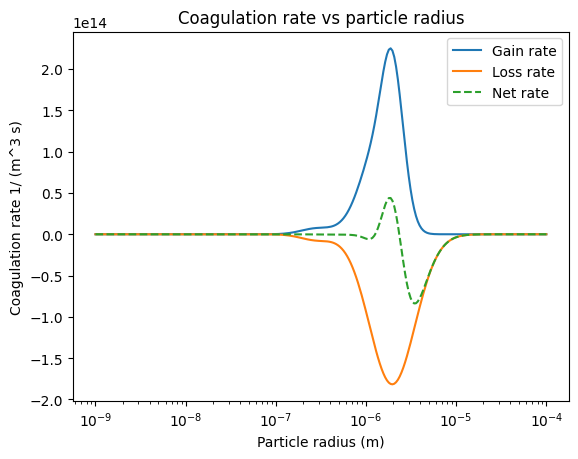

In [10]:
fig, ax = plt.subplots()
ax.plot(radius_bins, number_concentration)
ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlabel("Particle radius (m)")
ax.set_ylabel("Number concentration (1/m^3)")
ax.set_title("Number concentration vs particle radius")
plt.show()

# plot the rates
fig, ax = plt.subplots()
ax.plot(radius_bins, gain_rate, label="Gain rate")
ax.plot(radius_bins, -1*loss_rate, label="Loss rate")
ax.plot(radius_bins, net_rate, label="Net rate", linestyle="--")
ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlabel("Particle radius (m)")
ax.set_ylabel("Coagulation rate 1/ (m^3 s)")
ax.set_title("Coagulation rate vs particle radius")
ax.legend()
plt.show()